In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, fcluster

In [2]:
df_raw = pd.read_csv('merged_data.csv', sep = '\t')
df_raw = df_raw.dropna(subset=['roe_num']) # Drop les lignes sans valeurs pour ROE

# Sélectionner les bornes à partir desquelles les valeures sont trop fortes
df_raw = df_raw[df_raw['roe_num'] > -100]
df_raw = df_raw[df_raw['roe_num'] < 100] 
df_raw = df_raw[df_raw['Year'] != 2022] # On ne garde pas les données de 2022 car il n'y a pas assez de données
df_raw.shape
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3951 entries, 0 to 4171
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       3951 non-null   object 
 1   grade      3951 non-null   float64
 2   country    3951 non-null   object 
 3   industry   3951 non-null   object 
 4   employees  3951 non-null   object 
 5   roe        3951 non-null   object 
 6   Year       3951 non-null   int64  
 7   roe_num    3951 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 277.8+ KB


In [3]:
# Travailler sur les secteurs comme ils sont présents dans la base ne permet pas de travailler avec de gros échantillons
# On va donc les regrouper dans de plus grands groupes
category_mapping = {
    'Retailing': 'Consumer sectors (B2C)',
    'Food Retailers': 'Consumer sectors (B2C)',
    'Consumer Durables': 'Consumer sectors (B2C)',
    'Household Products': 'Consumer sectors (B2C)',
    'Food Products': 'Consumer sectors (B2C)',
    'Textiles & Apparel': 'Consumer sectors (B2C)',
    'Consumer Services': 'Consumer sectors (B2C)',

    'Machinery': 'Industrial and manufacturing sectors',
    'Building Products': 'Industrial and manufacturing sectors',
    'Construction Materials': 'Industrial and manufacturing sectors',
    'Industrial Conglomerates': 'Industrial and manufacturing sectors',
    'Auto Components': 'Industrial and manufacturing sectors',
    'Steel': 'Industrial and manufacturing sectors',
    'Containers & Packaging': 'Industrial and manufacturing sectors',
    'Paper & Forestry': 'Industrial and manufacturing sectors',
    'Construction & Engineering': 'Industrial and manufacturing sectors',

    'Software & Services': 'Technology sectors',
    'Technology Hardware': 'Technology sectors',
    'Semiconductors': 'Technology sectors',
    'Telecommunication Services': 'Technology sectors',

    'Banks': 'Financial sectors',
    'Diversified Financials': 'Financial sectors',
    'Insurance': 'Financial sectors',

    'Pharmaceuticals': 'Healthcare and well-being',
    'Healthcare': 'Healthcare and well-being',

    'Oil & Gas Producers': 'Energy and natural resources',
    'Energy Services': 'Energy and natural resources',
    'Refiners & Pipelines': 'Energy and natural resources',
    'Precious Metals': 'Energy and natural resources',
    'Diversified Metals': 'Energy and natural resources',

    'Transportation': 'Transport and logistics',
    'Transportation Infrastructure': 'Transport and logistics',
    'Aerospace & Defense': 'Transport and logistics',
    'Traders & Distributors': 'Transport and logistics',

    'Real Estate': 'Real estate and related services',
    'Homebuilders': 'Real estate and related services',

    'Media': 'Commercial services and media',
    'Commercial Services': 'Commercial services and media',

    'Utilities': 'Utilities'
}


# Remplacement de la colonne 'industry' par les catégories
df = df_raw.copy()
df['global_industry'] = df_raw['industry'].map(category_mapping)

In [4]:
# On fait de même pour les pays, en les regroupant par continent
european_country = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
    'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
    'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
    'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Switzerland', 'Norway', 'Iceland'
]

north_america = ['United States of America', 'Canada', 'Mexico', 'Bermuda', 'Puerto Rico', 'Cayman Islands']

south_america = [
    'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador',
    'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'
]

asian_country = [
    'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan',
    'Brunei', 'Cambodia', 'China', 'Georgia', 'India', 'Indonesia', 'Iran',
    'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan',
    'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal',
    'North Korea', 'Oman', 'Pakistan', 'Philippines', 'Qatar', 'Saudi Arabia',
    'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Tajikistan', 'Thailand',
    'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates',
    'Uzbekistan', 'Vietnam', 'Yemen', 'Taiwan', 'Hong Kong'
]

african_country = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
    'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
    'Congo', 'Congo (Democratic Republic)', 'Djibouti', 'Egypt', 'Equatorial Guinea',
    'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
    'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi',
    'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia',
    'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles',
    'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania',
    'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

oceania = [
    'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia',
    'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa',
    'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'
]

other_countries = ['Aland Islands', 'Gibraltar']

def get_continent(country):
    if country in european_country:
        return 'Europe'
    elif country in north_america:
        return 'North America'
    elif country in south_america:
        return 'South America'
    elif country in asian_country:
        return 'Asia'
    elif country in african_country:
        return 'Africa'
    elif country in oceania:
        return 'Oceania'
    elif country in other_countries:
        return 'Other'
    else:
        return 'Unknown'

df['continent'] = df['country'].apply(get_continent)

df_europe = df[df['country'].isin(european_country)]
df_north_america = df[df['country'].isin(north_america)]
df_south_america = df[df['country'].isin(south_america)]
df_asia = df[df['country'].isin(asian_country)]
df_africa = df[df['country'].isin(african_country)]
df_oceania = df[df['country'].isin(oceania)]

# On ne garde que les continents Europe, North America et Asia puisque ce sont ceux disposant de sufffisement de données
df = df[df['continent'].isin(['Europe', 'North America', 'Asia'])]
df.shape

(3813, 10)

In [5]:
df.to_csv('the_final_merged_file.csv', sep = '\t', index = False)

In [6]:
def check_number_of_observations(dataframe, year):
    """
    Cette fonction a pour but de retourner le nombre d'observations par secteur pour une année donnée et d'ainsi
    pouvoir sélectionner les secteur, pays et années sur lesquelles il est pertinent d'efféctuer une étude de clustering

    """
    osbevations = {} # Création d'un dictionnaire vide
    for sector in dataframe['global_industry'].unique(): # On vient chercher tout les secteurs
        osbevations[sector] = dataframe[(dataframe['global_industry'] == sector) & (dataframe['Year'] == year)].shape[0] # On ajoute pour chaque secteur le nombre d'observations
        observations_df = pd.DataFrame.from_dict(osbevations, orient='index', columns=['Number of observations']) # On transforme le dictionnaire en dataframe
    return observations_df.sort_values(by='Number of observations', ascending=False).head(10) # On affichel es 10 secteurs avec le plus d'observations


def elbow(dataframe, sector, year):
    """ 
    Cette fonction a pour but de retourner les données standardisées et d'afficher un graphique permettant de déterminer le nombre de clusters optimal pour un 
    secteur donné via la méthode du coude

    dataframe : Le Dataframe que l'on souhaite analyser
    sector : Le secteur sur lequel on souhaite effectuer l'analyse
    year : L'année sur laquelle on souhaite effectuer l'analy

    Return : Les données standardisées

    """

    datas = dataframe[(dataframe['global_industry'] == sector) & (dataframe['Year'] == year)]
    scaler = StandardScaler()
    datas_scaled = scaler.fit_transform(datas[['roe_num', 'grade']])
    datas_scaled_df = pd.DataFrame(datas_scaled, columns=['roe_num', 'grade'])
    inertia = []
    for i in range(1, 11): # On teste jusqu'à 10 clusters
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(datas_scaled_df)
        inertia.append(kmeans.inertia_)
    fig = px.line(x=range(1, 11), y=inertia, labels={'x': 'Number of clusters', 'y': 'WCSS'}, title='Elbow method')
    fig.update_layout(width=800, height=600)
    fig.show()
    return datas_scaled_df



def hierarchical_clustering(dataframe):
    """ 
    Cette fonction a pour but d'afficher le dendrogramme pour un secteur donné

    dataframe : Le Dataframe que l'on souhaite analyser avec les données standardisées
    
    """
    plt.figure(figsize=(10, 6))
    dendrogram = sch.dendrogram(sch.linkage(dataframe, method  = "ward"))
    plt.xlabel('Companies')
    plt.ylabel('Euclidean distances')
    plt.show()

    
def plot_clusters(dataframe, n_clusters, method):
    """ 
    Cette fonction a pour but d'afficher la répartition des données pour un secteur et une année donné avec les clusters obtenus
    par la méthode de clustering choisie (Kmeans ou Hierarchical)

    dataframe : Le Dataframe que l'on souhaite analyser normalisé
    n_clusters : Le nombre de clusters souhaité
    method : La méthode de clustering choisie (Kmeans ou Hierarchical)
    
    """

    df_copy = dataframe.copy()
    if method == 'kmeans':
        kmeans = KMeans(n_clusters = n_clusters, random_state=0)
        clusters = kmeans.fit_predict(df_copy)
    elif method == 'hierarchical':
        Z = linkage(df_copy, method='ward')
        clusters = fcluster(Z, t = n_clusters, criterion='maxclust')

    df_copy['cluster'] = clusters
    df_copy['cluster'] = df_copy['cluster'].astype(str)
    scatter_fig = px.scatter(
        df_copy, 
        x='grade', 
        y='roe_num', 
        color='cluster',
        color_discrete_sequence=["red","blue", "green", "purple"],  # Liste de couleurs personnalisées, on peut en ajouter si besoin
        labels={"roe_num": "ROE", "grade": "ESG Score", "cluster": "Cluster"},
        width=800,
        height=600,
    )
    scatter_fig.show()


def pearson_corr(dataframe):
    """ 
    Cette fonction a pour but de calculer le coefficient de corrélation de Pearson entre le ROE et la note ESG

    dataframe : Le Dataframe que l'on souhaite analyser

    Return : Le coefficient de corrélation de Pearson et la p-value associée
    """


    corr, p_values = pearsonr(dataframe['roe_num'], dataframe['grade'])
    print(f"The Pearson Correlation Coefficient is {np.round(corr, 2)} with a P-value of {np.round(p_values,2)}")
    if p_values < 0.05:
        print("The correlation is statistically significant")
        if corr > 0:
            print("The correlation is positive")
        else:
            print("The correlation is negative")
    elif p_values > 0.05:
        print("The correlation is not statistically significant")
    return corr, p_values  


def summarize_correlations(dataframe):
    """ 
    Cette fonction a pour but de résumer les corrélations pour chaque combinaison de continent, année et secteur

    dataframe : Le Dataframe que l'on souhaite analyser

    Return : Un Dataframe contenant les résultats

    """
    results = []
    for continent in dataframe['continent'].unique():
        for year in dataframe['Year'].unique():
            for sector in dataframe['global_industry'].unique():
                subset = dataframe[(dataframe['continent'] == continent) & 
                                   (dataframe['Year'] == year) & 
                                   (dataframe['global_industry'] == sector)]
                if len(subset) > 1: 
                    scaler = StandardScaler()
                    subset[['roe_num', 'grade']] = scaler.fit_transform(subset[['roe_num', 'grade']])
                    
                    corr, p_value = pearson_corr(subset)
                    result = {
                        'continent': continent,
                        'Year': year,
                        'sector': sector,
                        'correlation': np.round(corr, 2),
                        'p_value': np.round(p_value, 2),
                        'significant': p_value < 0.05,
                        'direction': 'positive' if corr > 0 else 'negative'
                    }
                    results.append(result)

    results_df = pd.DataFrame(results)
    return results_df

In [7]:
check_number_of_observations(df_north_america, 2024)

,Number of observations
Financial sectors,92
Technology sectors,81
Consumer sectors (B2C),73
Healthcare and well-being,73
Real estate and related services,59
Energy and natural resources,58
Industrial and manufacturing sectors,55
Commercial services and media,26
Transport and logistics,26
Utilities,26


In [8]:
datas_scaled = elbow(df_europe, 'Financial sectors', 2024)

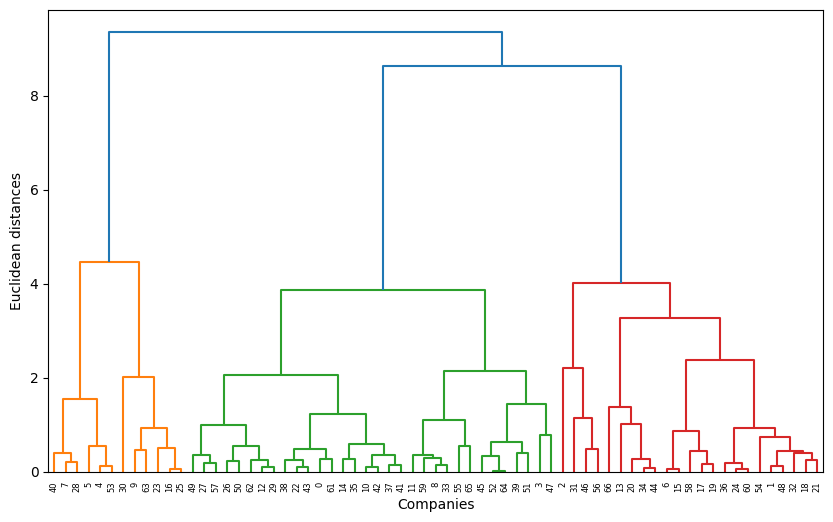

In [9]:
hierarchical_clustering(datas_scaled)

In [10]:
plot_clusters(datas_scaled, 3, 'kmeans')

In [11]:
pearson_corr(datas_scaled)

The Pearson Correlation Coefficient is 0.13 with a P-value of 0.3
The correlation is not statistically significant


(np.float64(0.1283051423069854), np.float64(0.30078892804354096))

In [12]:
df_pearson = summarize_correlations(df)

The Pearson Correlation Coefficient is -0.0 with a P-value of 1.0
The correlation is not statistically significant
The Pearson Correlation Coefficient is -0.33 with a P-value of 0.0
The correlation is statistically significant
The correlation is negative
The Pearson Correlation Coefficient is -0.29 with a P-value of 0.01
The correlation is statistically significant
The correlation is negative
The Pearson Correlation Coefficient is -0.24 with a P-value of 0.02
The correlation is statistically significant
The correlation is negative
The Pearson Correlation Coefficient is -0.33 with a P-value of 0.11
The correlation is not statistically significant
The Pearson Correlation Coefficient is 0.05 with a P-value of 0.82
The correlation is not statistically significant
The Pearson Correlation Coefficient is 0.06 with a P-value of 0.68
The correlation is not statistically significant
The Pearson Correlation Coefficient is -0.27 with a P-value of 0.05
The correlation is statistically significant
T

C:\Users\PC\AppData\Local\Temp\ipykernel_4944\798744117.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_4944\798744117.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_4944\798744117.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

The Pearson Correlation Coefficient is 0.13 with a P-value of 0.4
The correlation is not statistically significant
The Pearson Correlation Coefficient is 0.08 with a P-value of 0.66
The correlation is not statistically significant
The Pearson Correlation Coefficient is -0.06 with a P-value of 0.59
The correlation is not statistically significant
The Pearson Correlation Coefficient is -0.18 with a P-value of 0.03
The correlation is statistically significant
The correlation is negative
The Pearson Correlation Coefficient is -0.14 with a P-value of 0.51
The correlation is not statistically significant
The Pearson Correlation Coefficient is -0.2 with a P-value of 0.3
The correlation is not statistically significant
The Pearson Correlation Coefficient is -0.4 with a P-value of 0.0
The correlation is statistically significant
The correlation is negative
The Pearson Correlation Coefficient is -0.32 with a P-value of 0.0
The correlation is statistically significant
The correlation is negative


C:\Users\PC\AppData\Local\Temp\ipykernel_4944\798744117.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_4944\798744117.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_4944\798744117.py:132: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [13]:
df_pearson

,continent,Year,sector,correlation,p_value,significant,direction
0,North America,2024,Consumer sectors (B2C),-0.00,1.00,False,negative
1,North America,2024,Technology sectors,-0.33,0.00,True,negative
2,North America,2024,Healthcare and well-being,-0.29,0.01,True,negative
3,North America,2024,Financial sectors,-0.24,0.02,True,negative
4,North America,2024,Transport and logistics,-0.33,0.11,False,negative
5,North America,2024,Commercial services and media,0.05,0.82,False,positive
6,North America,2024,Real estate and related services,0.06,0.68,False,positive
7,North America,2024,Industrial and manufacturing sectors,-0.27,0.05,True,negative
8,North America,2024,Utilities,0.36,0.07,False,positive
9,North America,2024,Energy and natural resources,-0.01,0.94,False,negative


In [14]:
def plot_significance_pie_charts(results_df):
    """ 
    Cette fonction a pour but  de créer des graphiques en camembert pour chaque continent afin de visualiser la proportion de corrélations significatives
    sur les 2 années étudiées

    results_df : Le Dataframe contenant les résultats des corrélations
    
    """
    results_df['significant'] = results_df['significant'].map({True: 'Yes', False: 'No'})
    significance_counts = results_df.groupby(['continent', 'significant']).size().reset_index(name='count')
    
    for continent in results_df['continent'].unique():
        continent_data = significance_counts[significance_counts['continent'] == continent]
        fig = px.pie(
            continent_data, 
            names='significant', 
            values='count', 
            title=f'Significance Proportion for {continent}',
            labels={'significant': 'Significant', 'count': 'Count'}
        )
        # Désactiver les pourcentages et afficher uniquement les valeurs brutes
        fig.update_traces(textinfo='label+value')
        fig.update_layout(width=800, height=600, legend_title_text='Is there a correlation?')
        fig.show()
plot_significance_pie_charts(df_pearson)

In [15]:
def plot_significant_correlation_directions(results_df):
    """ 
    Cette fonction a pour but de créer des graphiques en camembert pour chaque continent afin de visualiser la direction des corrélations significatives
    et de voir si les relations sont donc négatives ou positives

    results_df : Le Dataframe contenant les résultats des corrélations
    
    """
    significant_results = results_df[results_df['significant'] == 'Yes']

    direction_counts = significant_results.groupby(['continent', 'direction']).size().reset_index(name='count')

    for continent in direction_counts['continent'].unique():
        continent_data = direction_counts[direction_counts['continent'] == continent]
        fig = px.pie(
            continent_data,
            names='direction',
            values='count',
            title=f'Significant Correlation Directions for {continent}',
            labels={'direction': 'Direction', 'count': 'Count'}
        )
        fig.update_traces(textinfo='label+value')
        fig.update_layout(width=800, height=600, legend_title_text='Direction')
        fig.show()
        
plot_significant_correlation_directions(df_pearson)